# Chapter 5

*Modeling and Simulation in Python* Edit by Chun San Yip 14 June 2021

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [ ]:
# check if the libraries we need are installed

try:
    import pint
except ImportError:
    !pip install pint
    import pint
    
try:
    from modsim import *
except ImportError:
    !pip install modsimpy
    from modsim import *

## Reading data

Pandas is a library that provides tools for reading and processing data.  `read_html` reads a web page from a file or the Internet and creates one `DataFrame` for each table on the page.

In [2]:
from pandas import read_html

The following cell downloads a copy of https://en.wikipedia.org/wiki/World_population_estimates

In [ ]:
import os

filename = 'World_population_estimates.html'

if not os.path.exists(filename):
    !wget https://raw.githubusercontent.com/AllenDowney/ModSimPy/master/data/World_population_estimates.html

In [4]:
tables = read_html(filename, header=0, index_col=0, decimal='M')
len(tables)

6

The arguments of `read_html` specify the file to read and how to interpret the tables in the file.  The result, `tables`, is a sequence of `DataFrame` objects; `len(tables)` reports the length of the sequence.

We can select the `DataFrame` we want using the bracket operator.  The tables are numbered from 0, so `tables[2]` is actually the third table on the page.

`head` selects the header and the first five rows.

In [ ]:
table2 = tables[2]
table2.head()

`tail` selects the last five rows.

In [ ]:
table2.tail()

Long column names are awkard to work with, but we can replace them with abbreviated names.

In [7]:
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

Here's what the DataFrame looks like now.  

In [8]:
table2.head()

,census,prb,un,maddison,hyde,tanton,biraben,mj,thomlinson,durand,clark
Year,,,,,,,,,,,
1950,2557628654,2.516000e+09,2.525149e+09,2.544000e+09,2.527960e+09,2.400000e+09,2.527000e+09,2.500000e+09,2.400000e+09,NaN,2.486000e+09
1951,2594939877,NaN,2.572851e+09,2.571663e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,2636772306,NaN,2.619292e+09,2.617949e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,2682053389,NaN,2.665865e+09,2.665959e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,2730228104,NaN,2.713172e+09,2.716927e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The first column, which is labeled `Year`, is special.  It is the **index** for this `DataFrame`, which means it contains the labels for the rows.

Some of the values use scientific notation; for example, `2.544000e+09` is shorthand for $2.544 \cdot 10^9$ or 2.544 billion.

`NaN` is a special value that indicates missing data.

### Series

We can use dot notation to select a column from a `DataFrame`.  The result is a `Series`, which is like a `DataFrame` with a single column.

In [9]:
census = table2.census
census.head()

Year
1950    2557628654
1951    2594939877
1952    2636772306
1953    2682053389
1954    2730228104
Name: census, dtype: int64

In [10]:
census.tail()

Year
2012    7013871313
2013    7092128094
2014    7169968185
2015    7247892788
2016    7325996709
Name: census, dtype: int64

Like a `DataFrame`, a `Series` contains an index, which labels the rows.

`1e9` is scientific notation for $1 \cdot 10^9$ or 1 billion.

From here on, we will work in units of billions.

In [19]:
un = table2.un / 1e9
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [12]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

Here's what these estimates look like.

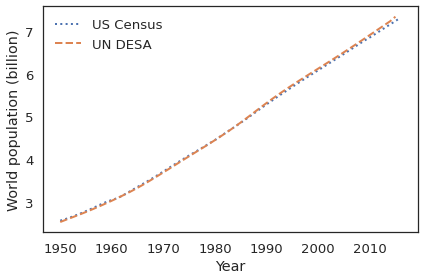

In [13]:
plot(census, ':', label='US Census')
plot(un, '--', label='UN DESA')
    
decorate(xlabel='Year',
         ylabel='World population (billion)')

The following expression computes the elementwise differences between the two series, then divides through by the UN value to produce [relative errors](https://en.wikipedia.org/wiki/Approximation_error), then finds the largest element.

So the largest relative error between the estimates is about 1.3%.

In [20]:
max(abs(census - un) / un) * 100

1.3821293828998855

**Exercise:** Break down that expression into smaller steps and display the intermediate results, to make sure you understand how it works.

1.  Compute the elementwise differences, `census - un`
2.  Compute the absolute differences, `abs(census - un)`
3.  Compute the relative differences, `abs(census - un) / un`
4.  Compute the percent differences, `abs(census - un) / un * 100`


In [21]:
census-un

Year
1950    0.032480
1951    0.022089
1952    0.017480
1953    0.016188
1954    0.017056
          ...   
2012   -0.066201
2013   -0.069991
2014   -0.073816
2015   -0.101579
2016         NaN
Length: 67, dtype: float64

In [22]:
abs(census-un)

Year
1950    0.032480
1951    0.022089
1952    0.017480
1953    0.016188
1954    0.017056
          ...   
2012    0.066201
2013    0.069991
2014    0.073816
2015    0.101579
2016         NaN
Length: 67, dtype: float64

In [23]:
abs(census - un) / un

Year
1950    0.012862
1951    0.008585
1952    0.006674
1953    0.006072
1954    0.006286
          ...   
2012    0.009350
2013    0.009772
2014    0.010190
2015    0.013821
2016         NaN
Length: 67, dtype: float64

In [24]:
abs(census - un) / un * 100

Year
1950    1.286247
1951    0.858540
1952    0.667365
1953    0.607232
1954    0.628640
          ...   
2012    0.935034
2013    0.977243
2014    1.019023
2015    1.382129
2016         NaN
Length: 67, dtype: float64

`max` and `abs` are built-in functions provided by Python, but NumPy also provides version that are a little more general.  When you import `modsim`, you get the NumPy versions of these functions.

### Constant growth

We can select a value from a `Series` using bracket notation.  Here's the first element:

In [34]:
census[1950]

2.557628654

And the last value.

In [35]:
census[2016]

7.325996709

But rather than "hard code" those dates, we can get the first and last labels from the `Series`:

In [43]:
t_0 = get_first_label(census)

In [44]:
t_end = get_last_label(census)

In [38]:
elapsed_time = t_end - t_0

And we can get the first and last values:

In [45]:
p_0 = get_first_value(census)

In [46]:
p_end = get_last_value(census)

Then we can compute the average annual growth in billions of people per year.

In [47]:
total_growth = p_end - p_0

In [62]:
annual_growth = total_growth / elapsed_time

### TimeSeries

Now let's create a `TimeSeries` to contain values generated by a linear growth model.

In [59]:
results = TimeSeries()

Initially the `TimeSeries` is empty, but we can initialize it so the starting value, in 1950, is the 1950 population estimated by the US Census.

In [51]:
results[t_0] = census[t_0]
results

,values
1950,2.557629


After that, the population in the model grows by a constant amount each year.

In [53]:
for t in linrange(t_0, t_end):
    results[t+1] = results[t] + annual_growth

Here's what the results looks like, compared to the actual data.

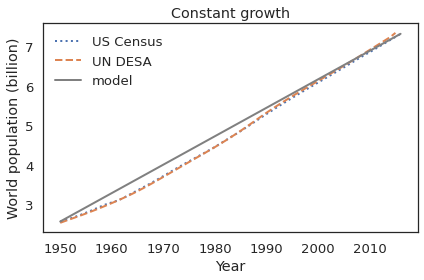

In [54]:
plot(census, ':', label='US Census')
plot(un, '--', label='UN DESA')
plot(results, color='gray', label='model')

decorate(xlabel='Year', 
         ylabel='World population (billion)',
         title='Constant growth')

The model fits the data pretty well after 1990, but not so well before.

### Exercises

**Optional Exercise:**  Try fitting the model using data from 1970 to the present, and see if that does a better job.

Hint: 

1. Copy the code from above and make a few changes.  Test your code after each small change.

2. Make sure your `TimeSeries` starts in 1950, even though the estimated annual growth is based on later data.

3. You might want to add a constant to the starting value to match the data better.

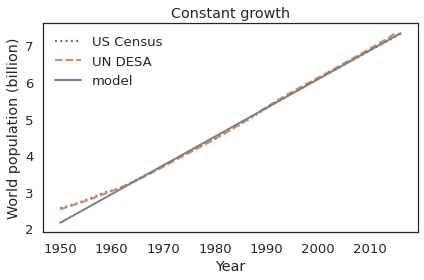

In [74]:
results2 = TimeSeries()
results2[t_0] = census[t_0]-0.4

total_growth2 = p_end - census[1970]
elapsed_time2 = t_end - 1970

annual_growth2 = total_growth2 / elapsed_time2

for t in linrange(t_0, t_end):
    results2[t+1] = results2[t] + annual_growth2

plot(census, ':', label='US Census')
plot(un, '--', label='UN DESA')
plot(results2, color='gray', label='model')

decorate(xlabel='Year', 
         ylabel='World population (billion)',
         title='Constant growth')

In [58]:
census.loc[1960:1970]

Year
1960    3.043002
1961    3.083967
1962    3.140093
1963    3.209828
1964    3.281201
1965    3.350426
1966    3.420678
1967    3.490334
1968    3.562314
1969    3.637159
1970    3.712698
Name: census, dtype: float64